In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
import numpy as np
import util

In [2]:
from sklearn import preprocessing 
from sklearn.metrics import pairwise 
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster 
from sklearn.cluster import KMeans 
from pandas.plotting import parallel_coordinates
from kmodes.kmodes import KModes

In [3]:
ksi_df = pd.read_csv('Data/KSI.csv')

In [4]:
pd.set_option('max_columns', None)

In [5]:
ksi_df = ksi_df.iloc[ksi_df['ACCNUM'].drop_duplicates().index]

In [6]:
ksi_df['INVTYPE'].str.contains('Driver')

0         True
2         True
4         True
7         True
9         True
         ...  
16848    False
16850     True
16852     True
16854     True
16856     True
Name: INVTYPE, Length: 6002, dtype: bool

In [7]:
# subset drivers so that only drivers are included

ksi_df = ksi_df[ksi_df['INVTYPE'].str.contains('Driver')]

# just for cross-referencing accidents

ksi_df2 = pd.read_csv('Data/KSI.csv')

In [8]:
ksi_df['LIGHT'] = ksi_df['LIGHT'].apply(util.lc)
ksi_df['TRAFFCTL'] = ksi_df['TRAFFCTL'].apply(util.tc)
ksi_df['DRIVACT'] = ksi_df['DRIVACT'].apply(util.actc)
ksi_df['DRIVCOND'] = ksi_df['DRIVCOND'].apply(util.condc)
ksi_df['VEHTYPE'] = ksi_df['VEHTYPE'].apply(util.vehc)
ksi_df['INVAGE'] = ksi_df['INVAGE'].apply(util.agec)

In [9]:
cols = ['VISIBILITY', 'LIGHT', 'RDSFCOND', 'IMPACTYPE', 'VEHTYPE', 'MANOEUVER', 'DRIVACT', 'DRIVCOND', 'TRAFFCTL', 'PEDACT', 'PEDCOND', 'ROAD_CLASS', 'DISTRICT', 'SPEEDING', 'ALCOHOL', 'REDLIGHT', 'AG_DRIV', 'CYCACT', 'CYCCOND']

In [10]:
cluster_cols = ksi_df[cols]

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 0, cost: 21515.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 0, cost: 21515.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 3, iteration: 1/100, moves: 0, cost: 21515.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 4, iteration: 1/100, moves: 0, cost: 21515.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 5, iteration: 1/100, moves: 0, cost: 21515.0
Best run was number 1
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 1061, cost: 18299.0
Run 1, iteration: 2/100, moves: 177, cost: 18299.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 1091, cost: 18882.0
Run 2, iteration: 

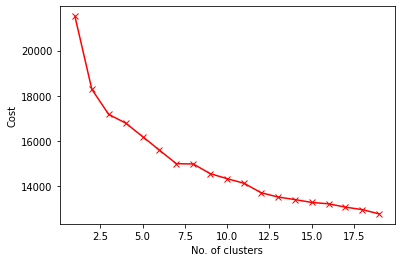

In [11]:
cost = []
K = range(1,20)
for num_clusters in list(K):
    kmode = KModes(n_clusters=num_clusters, init = "random", n_init = 5, verbose=1, random_state = 1)
    kmode.fit_predict(cluster_cols)
    cost.append(kmode.cost_)
    
plt.plot(K, cost, 'bx-', color = 'red')
plt.xlabel('No. of clusters')
plt.ylabel('Cost')
plt.show()

In [12]:
kmode = KModes(n_clusters= 10, init = "random", n_init = 5, verbose=0, random_state = 1)
clusters = kmode.fit_predict(cluster_cols)

In [13]:
# this is
kmode.labels_
# same as
clusters

array([2, 9, 4, ..., 7, 0, 2], dtype=uint16)

In [14]:
cluster_cols.insert(0, "Cluster", clusters, True)

In [15]:
cluster_cols

,Cluster,VISIBILITY,LIGHT,RDSFCOND,IMPACTYPE,VEHTYPE,MANOEUVER,DRIVACT,DRIVCOND,TRAFFCTL,PEDACT,PEDCOND,ROAD_CLASS,DISTRICT,SPEEDING,ALCOHOL,REDLIGHT,AG_DRIV,CYCACT,CYCCOND
0,2,Clear,Daylight,Dry,Pedestrian Collisions,Small-size Vehicle,Turning Left,Failed to Yield Right of Way,Unknown,Traffic Signal,<Null>,<Null>,Major Arterial,Toronto and East York,<Null>,<Null>,<Null>,Yes,<Null>,<Null>
2,9,Clear,Daylight,Dry,Turning Movement,Two Wheeler,Turning Right,Disobeyed Traffic Control,Unknown,Traffic Signal,<Null>,<Null>,Major Arterial,Scarborough,<Null>,<Null>,Yes,Yes,<Null>,<Null>
4,4,Clear,Dark,Dry,Pedestrian Collisions,Small-size Vehicle,Going Ahead,Other,Ability Impaired (Drugs/Alcohol),No Control,<Null>,<Null>,Major Arterial,Scarborough,<Null>,Yes,<Null>,<Null>,<Null>,<Null>
7,2,Clear,Dark,Dry,Pedestrian Collisions,Small-size Vehicle,Turning Left,Failed to Yield Right of Way,Ability Impaired (Drugs/Alcohol),Traffic Signal,<Null>,<Null>,Major Arterial,Toronto and East York,<Null>,Yes,<Null>,Yes,<Null>,<Null>
9,1,Clear,Daylight,Dry,Pedestrian Collisions,Small-size Vehicle,Going Ahead,Driving Properly,Normal,Traffic Signal,<Null>,<Null>,Major Arterial,Etobicoke York,<Null>,<Null>,<Null>,<Null>,<Null>,<Null>
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16846,1,Clear,Daylight,Dry,Cyclist Collisions,Small-size Vehicle,Stopped,Driving Properly,Normal,No Control,<Null>,<Null>,<Null>,<Null>,<Null>,<Null>,<Null>,<Null>,<Null>,<Null>
16850,6,Clear,Artificial,Dry,Rear End,Two Wheeler,Going Ahead,Speed too Fast For Condition,Inattentive,No Control,<Null>,<Null>,<Null>,<Null>,Yes,<Null>,<Null>,Yes,<Null>,<Null>
16852,7,Clear,Daylight,Dry,Turning Movement,Small-size Vehicle,Turning Left,Failed to Yield Right of Way,Normal,Traffic Signal,<Null>,<Null>,Major Arterial,North York,<Null>,<Null>,<Null>,Yes,<Null>,<Null>
16854,0,Clear,Daylight,Dry,Cyclist Collisions,Small-size Vehicle,Going Ahead,Improper Passing,Unknown,No Control,<Null>,<Null>,<Null>,<Null>,<Null>,<Null>,<Null>,Yes,<Null>,<Null>


In [16]:
cluster_cols[cluster_cols['Cluster'] == 0]

,Cluster,VISIBILITY,LIGHT,RDSFCOND,IMPACTYPE,VEHTYPE,MANOEUVER,DRIVACT,DRIVCOND,TRAFFCTL,PEDACT,PEDCOND,ROAD_CLASS,DISTRICT,SPEEDING,ALCOHOL,REDLIGHT,AG_DRIV,CYCACT,CYCCOND
48,0,Clear,Daylight,Dry,SMV Unattended Vehicle,Small-size Vehicle,Going Ahead,Driving Properly,Normal,No Control,<Null>,<Null>,Major Arterial,Etobicoke York,<Null>,<Null>,<Null>,<Null>,<Null>,<Null>
68,0,Clear,Dark,Dry,Rear End,Small-size Vehicle,Going Ahead,Driving Properly,Unknown,No Control,<Null>,<Null>,Major Arterial,Toronto and East York,<Null>,<Null>,<Null>,Yes,<Null>,<Null>
92,0,Clear,Daylight,Dry,Rear End,Small-size Vehicle,Stopped,Driving Properly,Normal,Traffic Signal,<Null>,<Null>,Major Arterial,Toronto and East York,<Null>,<Null>,<Null>,Yes,<Null>,<Null>
94,0,Clear,Daylight,Dry,Rear End,Small-size Vehicle,Going Ahead,Following too Close,Normal,Traffic Signal,<Null>,<Null>,Major Arterial,Etobicoke York,<Null>,<Null>,<Null>,Yes,<Null>,<Null>
98,0,Clear,Daylight,Dry,Angle,Small-size Vehicle,Going Ahead,Disobeyed Traffic Control,Normal,Stop/Yield Sign,<Null>,<Null>,Major Arterial,Toronto and East York,Yes,<Null>,<Null>,Yes,<Null>,<Null>
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16769,0,Clear,Daylight,Dry,Rear End,Small-size Vehicle,Going Ahead,Speed too Fast For Condition,Inattentive,No Control,<Null>,<Null>,<Null>,<Null>,Yes,<Null>,<Null>,Yes,<Null>,<Null>
16811,0,Clear,Daylight,Dry,Rear End,Small-size Vehicle,Going Ahead,Speed too Fast For Condition,Other,No Control,<Null>,<Null>,Major Arterial,Scarborough,Yes,<Null>,<Null>,Yes,<Null>,<Null>
16822,0,Clear,Daylight,Dry,Turning Movement,Medium-size Vehicle,Turning Right,Improper Turn,Inattentive,No Control,<Null>,<Null>,<Null>,<Null>,<Null>,<Null>,<Null>,Yes,<Null>,<Null>
16842,0,Clear,Daylight,Dry,Angle,Small-size Vehicle,Merging,Failed to Yield Right of Way,Normal,No Control,<Null>,<Null>,<Null>,<Null>,<Null>,<Null>,<Null>,Yes,<Null>,<Null>


In [17]:
cluster_cols[cluster_cols['Cluster'] == 0].apply(lambda x: x.mode())

,Cluster,VISIBILITY,LIGHT,RDSFCOND,IMPACTYPE,VEHTYPE,MANOEUVER,DRIVACT,DRIVCOND,TRAFFCTL,PEDACT,PEDCOND,ROAD_CLASS,DISTRICT,SPEEDING,ALCOHOL,REDLIGHT,AG_DRIV,CYCACT,CYCCOND
0,0,Clear,Daylight,Dry,Rear End,Small-size Vehicle,Going Ahead,Driving Properly,Normal,No Control,<Null>,<Null>,Major Arterial,Etobicoke York,<Null>,<Null>,<Null>,Yes,<Null>,<Null>


In [18]:
cluster_cols[cluster_cols['Cluster'] == 1].apply(lambda x: x.mode())

,Cluster,VISIBILITY,LIGHT,RDSFCOND,IMPACTYPE,VEHTYPE,MANOEUVER,DRIVACT,DRIVCOND,TRAFFCTL,PEDACT,PEDCOND,ROAD_CLASS,DISTRICT,SPEEDING,ALCOHOL,REDLIGHT,AG_DRIV,CYCACT,CYCCOND
0,1,Clear,Daylight,Dry,Pedestrian Collisions,Small-size Vehicle,Going Ahead,Driving Properly,Normal,No Control,<Null>,<Null>,Major Arterial,Toronto and East York,<Null>,<Null>,<Null>,<Null>,<Null>,<Null>


In [19]:
cluster_cols[cluster_cols['Cluster'] == 1]

,Cluster,VISIBILITY,LIGHT,RDSFCOND,IMPACTYPE,VEHTYPE,MANOEUVER,DRIVACT,DRIVCOND,TRAFFCTL,PEDACT,PEDCOND,ROAD_CLASS,DISTRICT,SPEEDING,ALCOHOL,REDLIGHT,AG_DRIV,CYCACT,CYCCOND
9,1,Clear,Daylight,Dry,Pedestrian Collisions,Small-size Vehicle,Going Ahead,Driving Properly,Normal,Traffic Signal,<Null>,<Null>,Major Arterial,Etobicoke York,<Null>,<Null>,<Null>,<Null>,<Null>,<Null>
20,1,Clear,Daylight,Dry,Pedestrian Collisions,Small-size Vehicle,Going Ahead,Failed to Yield Right of Way,Normal,Pedestrian Crossover,<Null>,<Null>,Major Arterial,Toronto and East York,<Null>,<Null>,<Null>,Yes,<Null>,<Null>
22,1,Clear,Daylight,Dry,Pedestrian Collisions,Small-size Vehicle,Going Ahead,Failed to Yield Right of Way,Normal,Stop/Yield Sign,<Null>,<Null>,Collector,Toronto and East York,<Null>,<Null>,<Null>,Yes,<Null>,<Null>
24,1,Clear,Daylight,Dry,Pedestrian Collisions,Small-size Vehicle,Going Ahead,Driving Properly,Normal,No Control,<Null>,<Null>,Major Arterial,Toronto and East York,<Null>,<Null>,<Null>,<Null>,<Null>,<Null>
43,1,Clear,Daylight,Dry,Pedestrian Collisions,Small-size Vehicle,Going Ahead,Driving Properly,Normal,Traffic Signal,<Null>,<Null>,Minor Arterial,Scarborough,<Null>,<Null>,<Null>,<Null>,<Null>,<Null>
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16791,1,Clear,Daylight,Dry,Pedestrian Collisions,Small-size Vehicle,Going Ahead,Driving Properly,Normal,No Control,<Null>,<Null>,<Null>,<Null>,<Null>,<Null>,<Null>,<Null>,<Null>,<Null>
16795,1,Clear,Daylight,Dry,Pedestrian Collisions,Large-size Vehicle,Going Ahead,Driving Properly,Normal,No Control,<Null>,<Null>,<Null>,<Null>,<Null>,<Null>,<Null>,<Null>,<Null>,<Null>
16824,1,Clear,Artificial,Dry,SMV Other,Two Wheeler,Unknown,Lost control,Normal,No Control,<Null>,<Null>,<Null>,<Null>,<Null>,<Null>,<Null>,<Null>,<Null>,<Null>
16840,1,Clear,Daylight,Dry,Pedestrian Collisions,Small-size Vehicle,Going Ahead,Driving Properly,Normal,No Control,<Null>,<Null>,<Null>,<Null>,<Null>,<Null>,<Null>,<Null>,<Null>,<Null>


In [20]:
cluster_cols[cluster_cols['Cluster'] == 2].apply(lambda x: x.mode())

,Cluster,VISIBILITY,LIGHT,RDSFCOND,IMPACTYPE,VEHTYPE,MANOEUVER,DRIVACT,DRIVCOND,TRAFFCTL,PEDACT,PEDCOND,ROAD_CLASS,DISTRICT,SPEEDING,ALCOHOL,REDLIGHT,AG_DRIV,CYCACT,CYCCOND
0,2,Clear,Daylight,Dry,Pedestrian Collisions,Small-size Vehicle,Turning Left,Failed to Yield Right of Way,Inattentive,Traffic Signal,<Null>,<Null>,Major Arterial,Scarborough,<Null>,<Null>,<Null>,Yes,<Null>,<Null>


In [21]:
cluster_cols[cluster_cols['Cluster'] == 3].apply(lambda x: x.mode())

,Cluster,VISIBILITY,LIGHT,RDSFCOND,IMPACTYPE,VEHTYPE,MANOEUVER,DRIVACT,DRIVCOND,TRAFFCTL,PEDACT,PEDCOND,ROAD_CLASS,DISTRICT,SPEEDING,ALCOHOL,REDLIGHT,AG_DRIV,CYCACT,CYCCOND
0,3,Clear,Daylight,Dry,Cyclist Collisions,Small-size Vehicle,Going Ahead,Other,Normal,No Control,<Null>,<Null>,Minor Arterial,Toronto and East York,<Null>,<Null>,<Null>,<Null>,<Null>,<Null>


In [22]:
cluster_cols[cluster_cols['Cluster'] == 4].apply(lambda x: x.mode())

,Cluster,VISIBILITY,LIGHT,RDSFCOND,IMPACTYPE,VEHTYPE,MANOEUVER,DRIVACT,DRIVCOND,TRAFFCTL,PEDACT,PEDCOND,ROAD_CLASS,DISTRICT,SPEEDING,ALCOHOL,REDLIGHT,AG_DRIV,CYCACT,CYCCOND
0,4,Clear,Dark,Dry,Pedestrian Collisions,Small-size Vehicle,Going Ahead,Speeding,Ability Impaired (Drugs/Alcohol),No Control,<Null>,<Null>,Major Arterial,Toronto and East York,Yes,Yes,<Null>,Yes,<Null>,<Null>


In [23]:
cluster_cols[cluster_cols['Cluster'] == 5].apply(lambda x: x.mode())

,Cluster,VISIBILITY,LIGHT,RDSFCOND,IMPACTYPE,VEHTYPE,MANOEUVER,DRIVACT,DRIVCOND,TRAFFCTL,PEDACT,PEDCOND,ROAD_CLASS,DISTRICT,SPEEDING,ALCOHOL,REDLIGHT,AG_DRIV,CYCACT,CYCCOND
0,5,Rain,Dark,Wet,Pedestrian Collisions,Small-size Vehicle,Going Ahead,Driving Properly,Normal,Traffic Signal,<Null>,<Null>,Major Arterial,Etobicoke York,<Null>,<Null>,<Null>,<Null>,<Null>,<Null>


In [24]:
cluster_cols[cluster_cols['Cluster'] == 6].apply(lambda x: x.mode())

,Cluster,VISIBILITY,LIGHT,RDSFCOND,IMPACTYPE,VEHTYPE,MANOEUVER,DRIVACT,DRIVCOND,TRAFFCTL,PEDACT,PEDCOND,ROAD_CLASS,DISTRICT,SPEEDING,ALCOHOL,REDLIGHT,AG_DRIV,CYCACT,CYCCOND
0,6,Clear,Artificial,Dry,SMV Other,Small-size Vehicle,Going Ahead,Lost control,Unknown,No Control,<Null>,<Null>,Major Arterial,Toronto and East York,Yes,<Null>,<Null>,Yes,<Null>,<Null>


In [25]:
cluster_cols[cluster_cols['Cluster'] == 7].apply(lambda x: x.mode())

,Cluster,VISIBILITY,LIGHT,RDSFCOND,IMPACTYPE,VEHTYPE,MANOEUVER,DRIVACT,DRIVCOND,TRAFFCTL,PEDACT,PEDCOND,ROAD_CLASS,DISTRICT,SPEEDING,ALCOHOL,REDLIGHT,AG_DRIV,CYCACT,CYCCOND
0,7,Clear,Daylight,Dry,Turning Movement,Small-size Vehicle,Turning Left,Failed to Yield Right of Way,Normal,Traffic Signal,<Null>,<Null>,Major Arterial,North York,<Null>,<Null>,<Null>,Yes,<Null>,<Null>


In [26]:
cluster_cols[cluster_cols['Cluster'] == 7].head(1)

,Cluster,VISIBILITY,LIGHT,RDSFCOND,IMPACTYPE,VEHTYPE,MANOEUVER,DRIVACT,DRIVCOND,TRAFFCTL,PEDACT,PEDCOND,ROAD_CLASS,DISTRICT,SPEEDING,ALCOHOL,REDLIGHT,AG_DRIV,CYCACT,CYCCOND
100,7,Clear,Daylight,Dry,Turning Movement,Small-size Vehicle,Stopped,Driving Properly,Normal,Traffic Signal,<Null>,<Null>,Major Arterial,North York,<Null>,<Null>,<Null>,<Null>,<Null>,<Null>


In [27]:
# checking cluster 7 data

ksi_df2[ksi_df2['ACCNUM'] == 892682]

,X,Y,INDEX_,ACCNUM,YEAR,DATE,TIME,HOUR,STREET1,STREET2,OFFSET,ROAD_CLASS,DISTRICT,WARDNUM,DIVISION,LATITUDE,LONGITUDE,LOCCOORD,ACCLOC,TRAFFCTL,VISIBILITY,LIGHT,RDSFCOND,ACCLASS,IMPACTYPE,INVTYPE,INVAGE,INJURY,FATAL_NO,INITDIR,VEHTYPE,MANOEUVER,DRIVACT,DRIVCOND,PEDTYPE,PEDACT,PEDCOND,CYCLISTYPE,CYCACT,CYCCOND,PEDESTRIAN,CYCLIST,AUTOMOBILE,MOTORCYCLE,TRUCK,TRSN_CITY_VEH,EMERG_VEH,PASSENGER,SPEEDING,AG_DRIV,REDLIGHT,ALCOHOL,DISABILITY,POLICE_DIVISION,HOOD_ID,NEIGHBOURHOOD,ObjectId
4,-8.822759e+06,5.424516e+06,3387793,892682,2006,2006/03/12 05:00:00+00,240,2,EGLINTON AVE E,COMMONWEALTH AVE,<Null>,Major Arterial,Scarborough,"21,20",41,43.734945,-79.25619,Mid-Block,<Null>,No Control,Clear,Dark,Dry,Fatal,Pedestrian Collisions,Driver,25 to 29,None,<Null>,West,"Automobile, Station Wagon",Going Ahead,Other,"Ability Impaired, Alcohol",<Null>,<Null>,<Null>,<Null>,<Null>,<Null>,Yes,<Null>,Yes,<Null>,<Null>,<Null>,<Null>,<Null>,<Null>,<Null>,<Null>,Yes,<Null>,D41,138,Eglinton East (138),5
5,-8.822759e+06,5.424516e+06,3387794,892682,2006,2006/03/12 05:00:00+00,240,2,EGLINTON AVE E,COMMONWEALTH AVE,<Null>,Major Arterial,Scarborough,"21,20",41,43.734945,-79.25619,Mid-Block,<Null>,No Control,Clear,Dark,Dry,Fatal,Pedestrian Collisions,Pedestrian,30 to 34,Minor,<Null>,South,Other,<Null>,<Null>,<Null>,Pedestrian hit at mid-block,"Crossing, no Traffic Control",Normal,<Null>,<Null>,<Null>,Yes,<Null>,Yes,<Null>,<Null>,<Null>,<Null>,<Null>,<Null>,<Null>,<Null>,Yes,<Null>,D41,138,Eglinton East (138),6
6,-8.822759e+06,5.424516e+06,3387795,892682,2006,2006/03/12 05:00:00+00,240,2,EGLINTON AVE E,COMMONWEALTH AVE,<Null>,Major Arterial,Scarborough,"21,20",41,43.734945,-79.25619,Mid-Block,<Null>,No Control,Clear,Dark,Dry,Fatal,Pedestrian Collisions,Pedestrian,40 to 44,Fatal,<Null>,South,Other,<Null>,<Null>,<Null>,Pedestrian hit at mid-block,"Crossing, no Traffic Control",Normal,<Null>,<Null>,<Null>,Yes,<Null>,Yes,<Null>,<Null>,<Null>,<Null>,<Null>,<Null>,<Null>,<Null>,Yes,<Null>,D41,138,Eglinton East (138),7


In [28]:
cluster_cols[cluster_cols['Cluster'] == 8].apply(lambda x: x.mode())

,Cluster,VISIBILITY,LIGHT,RDSFCOND,IMPACTYPE,VEHTYPE,MANOEUVER,DRIVACT,DRIVCOND,TRAFFCTL,PEDACT,PEDCOND,ROAD_CLASS,DISTRICT,SPEEDING,ALCOHOL,REDLIGHT,AG_DRIV,CYCACT,CYCCOND
0,8,Rain,Daylight,Wet,Pedestrian Collisions,Small-size Vehicle,Turning Left,Failed to Yield Right of Way,Normal,No Control,<Null>,<Null>,Minor Arterial,Toronto and East York,<Null>,<Null>,<Null>,Yes,<Null>,<Null>


In [29]:
cluster_cols[cluster_cols['Cluster'] == 8].head(1)

,Cluster,VISIBILITY,LIGHT,RDSFCOND,IMPACTYPE,VEHTYPE,MANOEUVER,DRIVACT,DRIVCOND,TRAFFCTL,PEDACT,PEDCOND,ROAD_CLASS,DISTRICT,SPEEDING,ALCOHOL,REDLIGHT,AG_DRIV,CYCACT,CYCCOND
56,8,Rain,Dark,Wet,Pedestrian Collisions,Small-size Vehicle,Unknown,Failed to Yield Right of Way,Unknown,No Control,<Null>,<Null>,Minor Arterial,Toronto and East York,<Null>,<Null>,<Null>,Yes,<Null>,<Null>


In [30]:
# driver not at fault, pedestrian flouted rules

ksi_df2[ksi_df2['ACCNUM'] == 893251]

,X,Y,INDEX_,ACCNUM,YEAR,DATE,TIME,HOUR,STREET1,STREET2,OFFSET,ROAD_CLASS,DISTRICT,WARDNUM,DIVISION,LATITUDE,LONGITUDE,LOCCOORD,ACCLOC,TRAFFCTL,VISIBILITY,LIGHT,RDSFCOND,ACCLASS,IMPACTYPE,INVTYPE,INVAGE,INJURY,FATAL_NO,INITDIR,VEHTYPE,MANOEUVER,DRIVACT,DRIVCOND,PEDTYPE,PEDACT,PEDCOND,CYCLISTYPE,CYCACT,CYCCOND,PEDESTRIAN,CYCLIST,AUTOMOBILE,MOTORCYCLE,TRUCK,TRSN_CITY_VEH,EMERG_VEH,PASSENGER,SPEEDING,AG_DRIV,REDLIGHT,ALCOHOL,DISABILITY,POLICE_DIVISION,HOOD_ID,NEIGHBOURHOOD,ObjectId
9,-8.855097e+06,5.418678e+06,3389258,893251,2006,2006/03/15 05:00:00+00,1535,15,ISLINGTON AVE,DIXON RD,<Null>,Major Arterial,Etobicoke York,"1,2",23,43.697045,-79.54669,Intersection,At Intersection,Traffic Signal,Clear,Daylight,Dry,Fatal,Pedestrian Collisions,Driver,40 to 44,None,<Null>,East,"Automobile, Station Wagon",Going Ahead,Driving Properly,Normal,<Null>,<Null>,<Null>,<Null>,<Null>,<Null>,Yes,<Null>,Yes,<Null>,<Null>,<Null>,<Null>,<Null>,<Null>,<Null>,<Null>,<Null>,<Null>,D23,6,Kingsview Village-The Westway (6),10
10,-8.855097e+06,5.418678e+06,3389259,893251,2006,2006/03/15 05:00:00+00,1535,15,ISLINGTON AVE,DIXON RD,<Null>,Major Arterial,Etobicoke York,"1,2",23,43.697045,-79.54669,Intersection,At Intersection,Traffic Signal,Clear,Daylight,Dry,Fatal,Pedestrian Collisions,Pedestrian,20 to 24,Fatal,<Null>,North,Other,<Null>,<Null>,<Null>,Vehicle is going straight thru inter.while ped...,Crossing without right of way,Normal,<Null>,<Null>,<Null>,Yes,<Null>,Yes,<Null>,<Null>,<Null>,<Null>,<Null>,<Null>,<Null>,<Null>,<Null>,<Null>,D23,6,Kingsview Village-The Westway (6),11


In [31]:
cluster_cols[cluster_cols['Cluster'] == 9].apply(lambda x: x.mode())

,Cluster,VISIBILITY,LIGHT,RDSFCOND,IMPACTYPE,VEHTYPE,MANOEUVER,DRIVACT,DRIVCOND,TRAFFCTL,PEDACT,PEDCOND,ROAD_CLASS,DISTRICT,SPEEDING,ALCOHOL,REDLIGHT,AG_DRIV,CYCACT,CYCCOND
0,9,Clear,Daylight,Dry,Angle,Small-size Vehicle,Going Ahead,Disobeyed Traffic Control,Inattentive,Traffic Signal,<Null>,<Null>,Major Arterial,Scarborough,<Null>,<Null>,Yes,Yes,<Null>,<Null>


In [32]:
cluster_cols[cluster_cols['Cluster'] == 9].head()

,Cluster,VISIBILITY,LIGHT,RDSFCOND,IMPACTYPE,VEHTYPE,MANOEUVER,DRIVACT,DRIVCOND,TRAFFCTL,PEDACT,PEDCOND,ROAD_CLASS,DISTRICT,SPEEDING,ALCOHOL,REDLIGHT,AG_DRIV,CYCACT,CYCCOND
2,9,Clear,Daylight,Dry,Turning Movement,Two Wheeler,Turning Right,Disobeyed Traffic Control,Unknown,Traffic Signal,<Null>,<Null>,Major Arterial,Scarborough,<Null>,<Null>,Yes,Yes,<Null>,<Null>
26,9,Clear,Dark,Dry,Angle,Small-size Vehicle,Going Ahead,Disobeyed Traffic Control,Ability Impaired (Drugs/Alcohol),Stop/Yield Sign,<Null>,<Null>,Minor Arterial,North York,<Null>,<Null>,<Null>,Yes,<Null>,<Null>
37,9,Clear,Daylight,Dry,Angle,Small-size Vehicle,Stopped,Driving Properly,Normal,Traffic Signal,<Null>,<Null>,Major Arterial,Scarborough,<Null>,<Null>,Yes,Yes,<Null>,<Null>
459,9,Clear,Daylight,Dry,Angle,Small-size Vehicle,Going Ahead,Disobeyed Traffic Control,Unknown,Traffic Signal,<Null>,<Null>,Major Arterial,Toronto and East York,<Null>,<Null>,Yes,Yes,<Null>,<Null>
466,9,Clear,Dark,Dry,Turning Movement,Small-size Vehicle,Going Ahead,Disobeyed Traffic Control,Normal,Traffic Signal,<Null>,<Null>,Major Arterial,Toronto and East York,<Null>,<Null>,Yes,Yes,<Null>,<Null>


In [33]:
ksi_df2[ksi_df2['ACCNUM'] == 901141]

,X,Y,INDEX_,ACCNUM,YEAR,DATE,TIME,HOUR,STREET1,STREET2,OFFSET,ROAD_CLASS,DISTRICT,WARDNUM,DIVISION,LATITUDE,LONGITUDE,LOCCOORD,ACCLOC,TRAFFCTL,VISIBILITY,LIGHT,RDSFCOND,ACCLASS,IMPACTYPE,INVTYPE,INVAGE,INJURY,FATAL_NO,INITDIR,VEHTYPE,MANOEUVER,DRIVACT,DRIVCOND,PEDTYPE,PEDACT,PEDCOND,CYCLISTYPE,CYCACT,CYCCOND,PEDESTRIAN,CYCLIST,AUTOMOBILE,MOTORCYCLE,TRUCK,TRSN_CITY_VEH,EMERG_VEH,PASSENGER,SPEEDING,AG_DRIV,REDLIGHT,ALCOHOL,DISABILITY,POLICE_DIVISION,HOOD_ID,NEIGHBOURHOOD,ObjectId
100,-8.839512e+06,5.425933e+06,3410195,901141,2006,2006/05/06 04:00:00+00,1830,18,YONGE ST,WILSON AVE,<Null>,Major Arterial,North York,"8,15",32,43.744145,-79.40669,Intersection,At Intersection,Traffic Signal,Clear,Daylight,Dry,Non-Fatal Injury,Turning Movement,Driver,40 to 44,Minor,<Null>,East,"Automobile, Station Wagon",Stopped,Driving Properly,Normal,<Null>,<Null>,<Null>,<Null>,<Null>,<Null>,<Null>,<Null>,Yes,<Null>,<Null>,<Null>,<Null>,Yes,<Null>,<Null>,<Null>,<Null>,Yes,D32,40,St.Andrew-Windfields (40),101
102,-8.839512e+06,5.425933e+06,3410196,901141,2006,2006/05/06 04:00:00+00,1830,18,YONGE ST,WILSON AVE,<Null>,Major Arterial,North York,"8,15",32,43.744145,-79.40669,Intersection,At Intersection,Traffic Signal,Clear,Daylight,Dry,Non-Fatal Injury,Turning Movement,Driver,25 to 29,Minor,<Null>,South,"Automobile, Station Wagon",Going Ahead,Driving Properly,Normal,<Null>,<Null>,<Null>,<Null>,<Null>,<Null>,<Null>,<Null>,Yes,<Null>,<Null>,<Null>,<Null>,Yes,<Null>,<Null>,<Null>,<Null>,Yes,D32,40,St.Andrew-Windfields (40),103
103,-8.839512e+06,5.425933e+06,3410197,901141,2006,2006/05/06 04:00:00+00,1830,18,YONGE ST,WILSON AVE,<Null>,Major Arterial,North York,"8,15",32,43.744145,-79.40669,Intersection,At Intersection,Traffic Signal,Clear,Daylight,Dry,Non-Fatal Injury,Turning Movement,Driver,90 to 94,Major,<Null>,North,"Automobile, Station Wagon",Turning Left,Improper Turn,Medical or Physical Disability,<Null>,<Null>,<Null>,<Null>,<Null>,<Null>,<Null>,<Null>,Yes,<Null>,<Null>,<Null>,<Null>,Yes,<Null>,<Null>,<Null>,<Null>,Yes,D32,40,St.Andrew-Windfields (40),104
910,-8.839512e+06,5.425933e+06,3410194,901141,2006,2006/05/06 04:00:00+00,1830,18,YONGE ST,WILSON AVE,<Null>,Major Arterial,North York,"8,15",32,43.744145,-79.40669,Intersection,At Intersection,Traffic Signal,Clear,Daylight,Dry,Non-Fatal Injury,Turning Movement,Passenger,65 to 69,Minor,<Null>,<Null>,Other,<Null>,<Null>,<Null>,<Null>,<Null>,<Null>,<Null>,<Null>,<Null>,<Null>,<Null>,Yes,<Null>,<Null>,<Null>,<Null>,Yes,<Null>,<Null>,<Null>,<Null>,Yes,D32,40,St.Andrew-Windfields (40),911


In [34]:
ksi_df2[ksi_df2['ACCNUM'] == 906284]

,X,Y,INDEX_,ACCNUM,YEAR,DATE,TIME,HOUR,STREET1,STREET2,OFFSET,ROAD_CLASS,DISTRICT,WARDNUM,DIVISION,LATITUDE,LONGITUDE,LOCCOORD,ACCLOC,TRAFFCTL,VISIBILITY,LIGHT,RDSFCOND,ACCLASS,IMPACTYPE,INVTYPE,INVAGE,INJURY,FATAL_NO,INITDIR,VEHTYPE,MANOEUVER,DRIVACT,DRIVCOND,PEDTYPE,PEDACT,PEDCOND,CYCLISTYPE,CYCACT,CYCCOND,PEDESTRIAN,CYCLIST,AUTOMOBILE,MOTORCYCLE,TRUCK,TRSN_CITY_VEH,EMERG_VEH,PASSENGER,SPEEDING,AG_DRIV,REDLIGHT,ALCOHOL,DISABILITY,POLICE_DIVISION,HOOD_ID,NEIGHBOURHOOD,ObjectId
113,-8.850065e+06,5.407830e+06,3424040,906284,2006,2006/05/09 04:00:00+00,710,7,THE QUEENSWAY,MORGAN AVE,<Null>,Major Arterial,Etobicoke York,3,22,43.626545,-79.50149,Intersection,At Intersection,Stop Sign,Clear,Daylight,Dry,Non-Fatal Injury,Turning Movement,Driver,65 to 69,Major,<Null>,North,"Automobile, Station Wagon",Turning Left,Improper Turn,Normal,<Null>,<Null>,<Null>,<Null>,<Null>,<Null>,<Null>,<Null>,Yes,<Null>,<Null>,<Null>,<Null>,Yes,<Null>,<Null>,<Null>,<Null>,<Null>,D22,16,Stonegate-Queensway (16),114
114,-8.850065e+06,5.407830e+06,3424041,906284,2006,2006/05/09 04:00:00+00,710,7,THE QUEENSWAY,MORGAN AVE,<Null>,Major Arterial,Etobicoke York,3,22,43.626545,-79.50149,Intersection,At Intersection,Stop Sign,Clear,Daylight,Dry,Non-Fatal Injury,Turning Movement,Passenger,30 to 34,Minor,<Null>,<Null>,Other,<Null>,<Null>,<Null>,<Null>,<Null>,<Null>,<Null>,<Null>,<Null>,<Null>,<Null>,Yes,<Null>,<Null>,<Null>,<Null>,Yes,<Null>,<Null>,<Null>,<Null>,<Null>,D22,16,Stonegate-Queensway (16),115
115,-8.850065e+06,5.407830e+06,3424042,906284,2006,2006/05/09 04:00:00+00,710,7,THE QUEENSWAY,MORGAN AVE,<Null>,Major Arterial,Etobicoke York,3,22,43.626545,-79.50149,Intersection,At Intersection,Stop Sign,Clear,Daylight,Dry,Non-Fatal Injury,Turning Movement,Vehicle Owner,unknown,None,<Null>,<Null>,Other,<Null>,<Null>,<Null>,<Null>,<Null>,<Null>,<Null>,<Null>,<Null>,<Null>,<Null>,Yes,<Null>,<Null>,<Null>,<Null>,Yes,<Null>,<Null>,<Null>,<Null>,<Null>,D22,16,Stonegate-Queensway (16),116
116,-8.850065e+06,5.407830e+06,3424043,906284,2006,2006/05/09 04:00:00+00,710,7,THE QUEENSWAY,MORGAN AVE,<Null>,Major Arterial,Etobicoke York,3,22,43.626545,-79.50149,Intersection,At Intersection,Stop Sign,Clear,Daylight,Dry,Non-Fatal Injury,Turning Movement,Driver,35 to 39,None,<Null>,East,"Automobile, Station Wagon",Going Ahead,Driving Properly,Normal,<Null>,<Null>,<Null>,<Null>,<Null>,<Null>,<Null>,<Null>,Yes,<Null>,<Null>,<Null>,<Null>,Yes,<Null>,<Null>,<Null>,<Null>,<Null>,D22,16,Stonegate-Queensway (16),117
